In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve

from librosa.core import stft
from librosa.core import istft
from librosa import amplitude_to_db, db_to_amplitude
from librosa.display import specshow
from librosa.output import write_wav

from scipy.signal import butter, lfilter

from utils import apply_reverb, read_wav
import corpus
import mir_eval

from beta_ntf_np import beta_NTF
import pyroomacoustics as pra

(-1, 9)

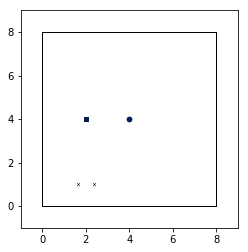

In [2]:
corners = np.array([[0,0], [0,8], [8,8], [8,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)

s1, s2 = map(read_wav, corpus.experiment_files_timit())

if len(s1) > len(s2):
    pad_length = len(s1) - len(s2)
    s2 = np.pad(s2, (0,pad_length), 'reflect')
else:
    pad_length = len(s2) - len(s1)
    s1 = np.pad(s1, (0,pad_length), 'reflect')

room.add_source([4.,4.], signal=s1)
room.add_source([2.,4.], signal=s2)

R = pra.linear_2D_array(center=[2.,1.], M=2, phi=0, d=0.75)
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))

fig, ax = room.plot()
ax.set_xlim([-1, 9])
ax.set_ylim([-1, 9])

3D case

(0, 6)

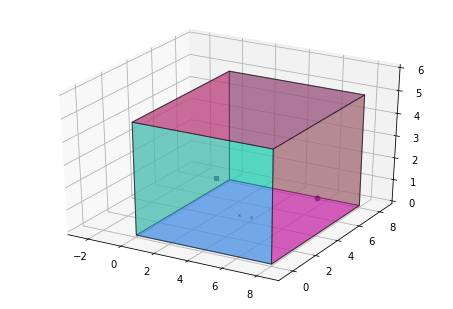

In [25]:
corners = np.array([[0,0], [0,8], [8,8], [8,0]]).T  # [x,y]
room = pra.Room.from_corners(corners)
room.extrude(5.)

s1, s2 = map(read_wav, corpus.experiment_files_timit())

if len(s1) > len(s2):
    pad_length = len(s1) - len(s2)
    s2 = np.pad(s2, (0,pad_length), 'reflect')
else:
    pad_length = len(s2) - len(s1)
    s1 = np.pad(s1, (0,pad_length), 'reflect')

room.add_source([8.,4.,1.6], signal=s1)
room.add_source([2.,4.,1.6], signal=s2)
#[[X],[Y],[Z]]
R = np.asarray([[4.75,5.5],[2.,2.],[1.,1]])
room.add_microphone_array(pra.MicrophoneArray(R, room.fs))
    
fig, ax = room.plot()
ax.set_xlim([-3, 9])
ax.set_ylim([-1, 9])
ax.set_zlim([0, 6])

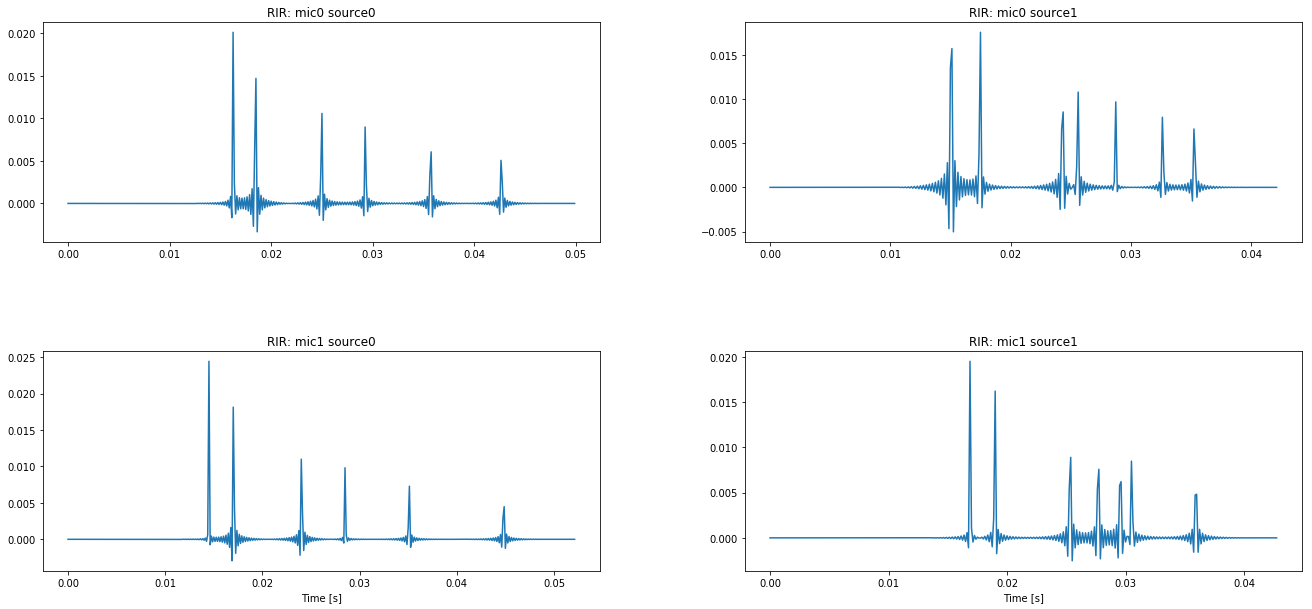

In [26]:
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

In [27]:
room.simulate()
print(room.mic_array.signals.shape)

(2, 47214)


In [28]:
nfft=2048
win = 1024
hop = nfft/8

Y1 = stft(room.mic_array.signals[0], n_fft=nfft, hop_length=hop, win_length=win)
Y2 = stft(room.mic_array.signals[1], n_fft=nfft, hop_length=hop, win_length=win)

In [29]:
I = 2
J = 2
IJ = I * J
F, T = Y1.shape
X = np.asarray([Y1, Y2])
K_partition = np.asarray([20,20])
# K_partition = np.asarray([50,50])
# K_partition = np.asarray([100,100])
# K_partition = np.asarray([150,150])
K = np.sum(K_partition)
print(X.shape)
mix_psd = 0.5 * (np.mean(np.power(np.abs(X[0,:,:]),2) + np.power(np.abs(X[1,:,:]),2),axis=1))
mix_psd = mix_psd.reshape((-1, 1))

A = 0.5 * np.multiply(1.9 * np.abs(np.random.randn(I,IJ,F)) + 0.1 * np.ones((I,IJ,F)),np.sign(np.random.randn(I,IJ,F) + 1j *np.random.randn(I,IJ,F)))
W = 0.5 * np.multiply(np.abs(np.random.randn(F,K)) + np.ones((F,K)), np.matmul(mix_psd, np.ones((1,K))))
H = 0.5 * np.abs(np.random.randn(K,T)) + np.ones((K,T))
Q = 0.5 * np.abs(np.random.randn(J,K)) + np.ones((J,K))
sigma_b = mix_psd / 100

QoH = np.zeros((J, T, K))
for k in range(K):
    Q_k = Q[:,k].reshape((-1, 1))
    H_k = H[k,:].reshape((1,-1))
    QoH[:,:,k] = np.matmul(Q_k, H_k)

V = np.zeros((J, F, T))
for j in range(J):
    V[j, :, :] = np.matmul(W, QoH[j,:,:].reshape((K, T)))

(2, 1025, 185)


In [33]:
bn = beta_NTF(W, H, X, A, sigma_b, Q, V, K_partition, epochs=1000)
bn.train()
A, V = bn.getAV()

beta_ntf_np.py:210: RuntimeWarning: invalid value encountered in log
  criterion = np.sum(np.divide(bar_P, self._V) - np.log(np.divide(bar_P, self._V))) - self.J*self.F*self.T


In [34]:
RV = np.zeros((I, I))
for j in range(J):
    start_index = (j*I)
    end_index = (j+1) * I
    RV = RV + np.matmul(A[:,start_index:end_index,0],np.conj(np.transpose(A[:,start_index:end_index,0]))) * V[j,0,0]
print(RV)

[[8.36632541e-06+0.j 8.19155310e-06+0.j]
 [8.19155310e-06+0.j 8.02197902e-06+0.j]]


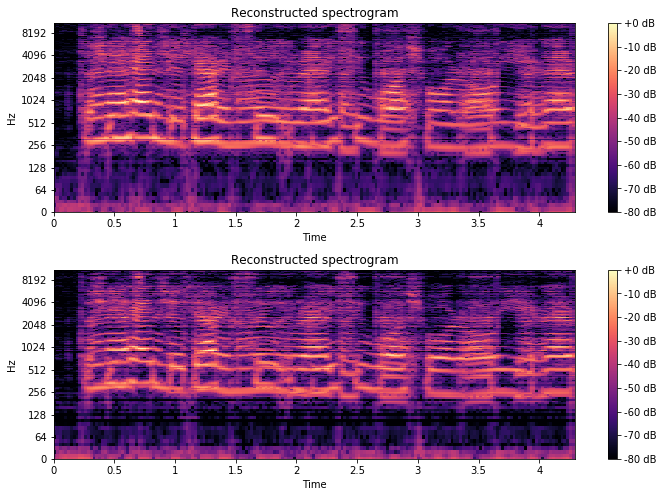

In [35]:

Y = bn.reconstruct()
plt.figure(figsize=(10,10))
ax1 = plt.subplot(311)
specshow(amplitude_to_db(Y[0,0], ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
ax1 = plt.subplot(312)
specshow(amplitude_to_db(Y[1,1], ref=np.max), y_axis='log', x_axis='time')
plt.title('Reconstructed spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
# plt.subplot(313, sharex=ax1)
# specshow(amplitude_to_db(S1, ref=np.max), y_axis='log', x_axis='time')
# plt.title('original spectrogram')
# plt.colorbar(format='%+2.0f dB')
# plt.tight_layout()